In [9]:
! pip install medmnist
! pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib
! pip install torchattacks

DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
zsh:1: no matches found: flwr[simulation]


*This* code is based on the documentation at: https://flower.dev/docs/framework/tutorial-series-get-started-with-flower-pytorch.html & https://flower.dev/docs/framework/tutorial-series-use-a-federated-learning-strategy-pytorch.html

Imports

In [10]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import os

import medmnist
from medmnist import INFO

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from torchvision import transforms
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from torchvision import models

import flwr as fl
from flwr.common import Metrics

import torchattacks

import warnings

DEVICE = torch.device("cpu")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")


ModuleNotFoundError: No module named 'flwr'

At first we load the MedMNIST chest X-ray classification dataset, set the amount of participants and IID distribute the data among them. Also transform the data to three channels.

In [ ]:
NUM_CLIENTS = 3
BATCH_SIZE = 32

In [ ]:
def load_data(num_clients, batch_size):
    # preprocessing
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    data_flag = 'chestmnist'
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])
    train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
    val_set = DataClass(split='val', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
    test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(num_clients):
        partition = int(len(train_set) / num_clients)
        indices = list(range(partition_id * partition, (partition_id + 1) * partition))
        train_set_partition = torch.utils.data.Subset(train_set, indices)
        trainloader = DataLoader(train_set_partition, batch_size=batch_size, shuffle=True)
        trainloaders.append(trainloader)

        partition_val = int(len(val_set) / num_clients)
        indices_val = list(range(partition_id * partition_val, (partition_id + 1) * partition_val))
        val_set_partition = torch.utils.data.Subset(val_set, indices_val)
        valloader = DataLoader(val_set_partition, batch_size=batch_size, shuffle=True)
        valloaders.append(valloader)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    print("Train set size: ", len(train_set))
    print("Partitioned train set size: ", len(train_set_partition))
    print("Validation set size: ", len(val_set))
    print("Partitioned validation set size: ", len(val_set_partition))
    print("Test set size: ", len(test_set))

    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_data(NUM_CLIENTS, BATCH_SIZE)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Train set size:  78468
Partitioned train set size:  26156
Validation set size:  11219
Partitioned validation set size:  3739
Test set size:  22433


Visualize all classes in the first trainloader partition

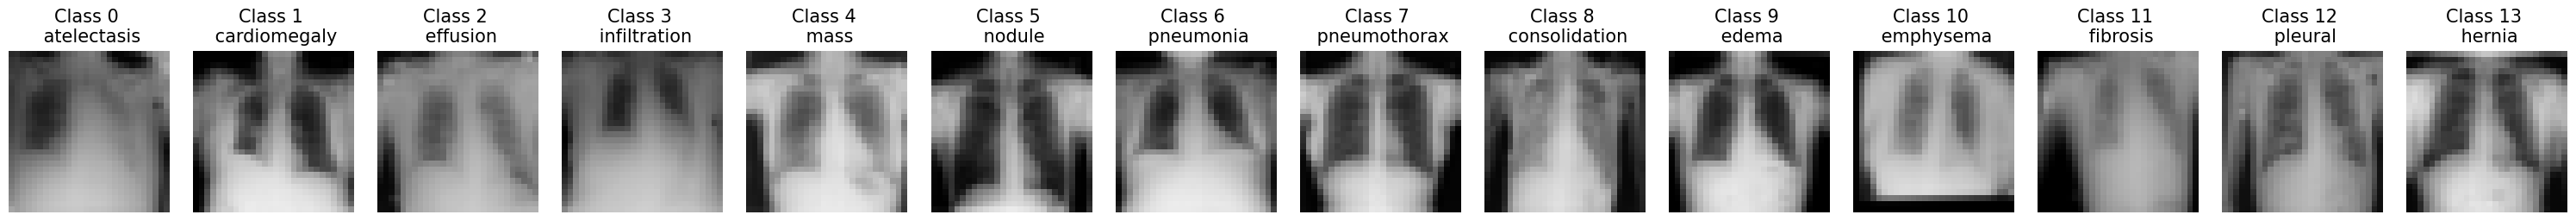

In [ ]:
batch = next(iter(trainloaders[0]))
images, labels = batch

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5
images = np.clip(images, 0, 1)
data_flag = 'chestmnist'
info = INFO[data_flag]

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 14, figsize=(30, 30))

# Loop over the images and plot them
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap="gray")
    ax.text(0.5, 1.15, f"Class {i} \n {info['label'][str(i)]}", ha='center', va='center', transform=ax.transAxes, fontsize=15)

    ax.axis('off')

# Show the plot
fig.tight_layout()
plt.show()

You are free to utilise any open-source framework for FL. Some recommendations from our side
include Flower

In [ ]:
model = models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def train(net, trainloader, learning_rate, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch
            images, labels = images.to(DEVICE), labels.to(DEVICE).long()
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
    return epoch_loss, epoch_acc


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch
            images, labels = images.to(DEVICE), labels.to(DEVICE).long()
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Train the model for 1 epoch to see if the training process works.

In [ ]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = model.to(DEVICE)

for epoch in range(1):
    train(net, trainloader, 0.001, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.0096414145475787, accuracy 0.9042524739235089
Final test set performance:
	loss 0.010381991945657814
	accuracy 0.8921232113404359


In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=False)

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader, client_metrics):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.client_metrics = client_metrics

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        learning_rate = config["learning_rate"]

        # Use values provided by the config
        set_parameters(self.net, parameters)
        train_loss, train_acc = train(self.net, self.trainloader, learning_rate=learning_rate, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        self.client_metrics["test_loss"].append(loss)
        self.client_metrics["test_accuracy"].append(accuracy)
        print(f"Client {self.cid} test loss: {loss}, test accuracy: {accuracy},  evaluate: {config}")
        return float(loss), len(self.valloader), {"cid" : self.cid, "accuracy": float(accuracy), "test_loss": float(loss), "config" : config}

In [ ]:
def client_fn(cid) -> FlowerClient:
    net = model.to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    client_metrics = {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": [],
    }

    return FlowerClient(cid, net, trainloader, valloader, client_metrics)

In [ ]:
# Check for available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

# Check for available CPUs
num_cpus = os.cpu_count()
print(f"Number of available CPUs: {num_cpus}")

Number of available GPUs: 1
Number of available CPUs: 2


The code below creates a FedAvg strategy with parameters set to ensure synchronous updates from all three clients.
The `fraction_fit` and `fraction_evaluate` parameters are set to 1, meaning all available clients are selected for
each round of training and evaluation. The `min_fit_clients`, `min_evaluate_clients`, and `min_available_clients`
parameters are set to 3, ensuring that all 3 clients are required for the training and evaluation processes.

In [ ]:
def individual_metrics(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Extract loss, accuracy, and cid from each client's metrics
    individual_metrics = [{"loss": m["test_loss"], "accuracy": m["accuracy"], "cid": m["cid"], "config": m["config"]} for _, m in metrics]

    # Return individual metrics
    return {"individual_metrics": individual_metrics}

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Train set size:  78468
Partitioned train set size:  7846
Validation set size:  11219
Partitioned validation set size:  1121
Test set size:  22433


INFO flwr 2024-01-23 17:16:56,046 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-01-23 17:16:58,641	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-23 17:17:00,795 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7678021632.0, 'object_store_memory': 3839010816.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7678021632.0, 'object_store_memory': 3839010816.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2024-01-23 17:17:00,799 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=39156) Client 6 test loss: 0.010840748286374864, test accuracy: 0.8983050847457628,  evaluate: {}


DEBUG flwr 2024-01-23 17:20:08,773 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2024-01-23 17:20:08,775 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=39156) Client 5 test loss: 0.011987754774348849, test accuracy: 0.8831400535236396,  evaluate: {} [repeated 9x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


DEBUG flwr 2024-01-23 17:22:50,820 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2024-01-23 17:22:51,390 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=39252) Client 5 test loss: 0.012531198142470258, test accuracy: 0.8831400535236396,  evaluate: {}
(DefaultActor pid=39157) Client 2 test loss: 0.008548189522856372, test accuracy: 0.9161462979482605,  evaluate: {}


DEBUG flwr 2024-01-23 17:22:57,458 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2024-01-23 17:22:57,462 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-01-23 17:25:34,971 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2024-01-23 17:25:35,539 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=39157) Client 1 test loss: 0.009434814748489676, test accuracy: 0.8974130240856378,  evaluate: {} [repeated 9x across cluster]
(DefaultActor pid=39252) Client 3 test loss: 0.009222118185632044, test accuracy: 0.8965209634255129,  evaluate: {} [repeated 8x across cluster]


DEBUG flwr 2024-01-23 17:25:42,524 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2024-01-23 17:25:42,528 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-01-23 17:28:22,706 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2024-01-23 17:28:23,279 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=39156) Client 8 test loss: 0.00813408992872187, test accuracy: 0.9152542372881356,  evaluate: {} [repeated 2x across cluster]


DEBUG flwr 2024-01-23 17:28:29,596 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2024-01-23 17:28:29,600 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-01-23 17:31:07,851 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2024-01-23 17:31:08,479 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=39157) Client 2 test loss: 0.008668303589380606, test accuracy: 0.9161462979482605,  evaluate: {} [repeated 10x across cluster]
(DefaultActor pid=39156) Client 8 test loss: 0.008148641361257628, test accuracy: 0.9152542372881356,  evaluate: {} [repeated 7x across cluster]


DEBUG flwr 2024-01-23 17:31:15,877 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
INFO flwr 2024-01-23 17:31:15,884 | server.py:153 | FL finished in 855.0179640399992
INFO:flwr:FL finished in 855.0179640399992
INFO flwr 2024-01-23 17:31:15,912 | app.py:226 | app_fit: losses_distributed [(1, 0.010569960403652408), (2, 0.009948985624383806), (3, 0.00956983541543068), (4, 0.009257167327248081), (5, 0.00968390603538978)]
INFO:flwr:app_fit: losses_distributed [(1, 0.010569960403652408), (2, 0.009948985624383806), (3, 0.00956983541543068), (4, 0.009257167327248081), (5, 0.00968390603538978)]
INFO flwr 2024-01-23 17:31:15,919 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2024-01-23 17:31:15,922 | app.py:228 | app_fit: metrics_distributed {'individual_metrics': [(1, [{'loss': 0.010222854808863521, 'accuracy': 0.9054415700267618, 'cid': '0', 'config'

History (loss, distributed):
	round 1: 0.010569960403652408
	round 2: 0.009948985624383806
	round 3: 0.00956983541543068
	round 4: 0.009257167327248081
	round 5: 0.00968390603538978
History (metrics, distributed, evaluate):
{'individual_metrics': [(1, [{'loss': 0.010222854808863521, 'accuracy': 0.9054415700267618, 'cid': '0', 'config': {}}, {'loss': 0.010809505905002275, 'accuracy': 0.8965209634255129, 'cid': '3', 'config': {}}, {'loss': 0.011987754774348849, 'accuracy': 0.8831400535236396, 'cid': '5', 'config': {}}, {'loss': 0.010614082622645052, 'accuracy': 0.8974130240856378, 'cid': '1', 'config': {}}, {'loss': 0.009377983268300515, 'accuracy': 0.9152542372881356, 'cid': '8', 'config': {}}, {'loss': 0.010311168733980908, 'accuracy': 0.903657448706512, 'cid': '9', 'config': {}}, {'loss': 0.010597858581289876, 'accuracy': 0.8983050847457628, 'cid': '7', 'config': {}}, {'loss': 0.011566252313906544, 'accuracy': 0.8893844781445138, 'cid': '4', 'config': {}}, {'loss': 0.00937139474181167

    Round Client ID      Loss  Accuracy
0       1         0  0.010223  0.905442
1       1         3  0.010810  0.896521
2       1         5  0.011988  0.883140
3       1         1  0.010614  0.897413
4       1         8  0.009378  0.915254
5       1         9  0.010311  0.903657
6       1         7  0.010598  0.898305
7       1         4  0.011566  0.889384
8       1         2  0.009371  0.916146
9       1         6  0.010841  0.898305
10      2         5  0.012531  0.883140
11      2         6  0.009743  0.898305
12      2         7  0.009564  0.898305
13      2         9  0.009367  0.903657
14      2         4  0.010497  0.889384
15      2         3  0.009611  0.896521
16      2         2  0.008548  0.916146
17      2         1  0.009703  0.897413
18      2         8  0.008344  0.915254
19      2         0  0.011581  0.905442
20      3         5  0.010310  0.883140
21      3         1  0.009435  0.897413
22      3         4  0.010140  0.889384
23      3         8  0.010470  0.915254


In [ ]:
NUM_CLIENTS = 3
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_ROUNDS = 5
LOCAL_EPOCHS = 3

trainloaders, valloaders, testloader = load_data(NUM_CLIENTS, BATCH_SIZE)
model = models.resnet18(pretrained=False)

def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": LOCAL_EPOCHS,
        "learning_rate": LEARNING_RATE,
    }
    return config

def client_fn(cid) -> FlowerClient:
    net = model.to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    client_metrics = {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": [],
    }

    return FlowerClient(cid, net, trainloader, valloader, client_metrics)

params = get_parameters(model)

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit = 1,
    fraction_evaluate = 1,
    min_fit_clients = NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=individual_metrics,
    on_fit_config_fn=fit_config,
)

# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are sharing the GPU among the clients.
    client_resources = {"num_cpus": 0.6, "num_gpus": 0.3}
    #client_resources = {"num_cpus": float(f"{(num_cpus / NUM_CLIENTS):.1f}"), "num_gpus": float(f"{(num_gpus / NUM_CLIENTS):.1f}")}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Train set size:  78468
Partitioned train set size:  26156
Validation set size:  11219
Partitioned validation set size:  3739
Test set size:  22433


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO flwr 2024-01-23 17:33:10,493 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-01-23 17:33:15,092	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-23 17:33:17,248 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3838568448.0, 'memory': 7677136896.0, 'CPU': 2.0, 'node:__internal_head_

(DefaultActor pid=45480) Client 1 test loss: 0.010088723542442229, test accuracy: 0.8924846215565659,  evaluate: {}


DEBUG flwr 2024-01-23 17:36:13,981 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:36:13,984 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-01-23 17:38:47,223 | server.py:236 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:38:47,413 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-01-23 17:38:52,740 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:38:52,743 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 3)


(DefaultActor pid=45480) Client 2 test loss: 0.00900138142028254, test accuracy: 0.9042524739235089,  evaluate: {} [repeated 3x across cluster]


DEBUG flwr 2024-01-23 17:41:25,642 | server.py:236 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:41:25,826 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 3)


(DefaultActor pid=45481) Client 2 test loss: 0.008832662498593873, test accuracy: 0.9042524739235089,  evaluate: {} [repeated 3x across cluster]


DEBUG flwr 2024-01-23 17:41:30,396 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:41:30,400 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-01-23 17:44:03,802 | server.py:236 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:44:03,990 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 3)


(DefaultActor pid=45481) Client 2 test loss: 0.008967580126788279, test accuracy: 0.9042524739235089,  evaluate: {} [repeated 3x across cluster]


DEBUG flwr 2024-01-23 17:44:10,127 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:44:10,130 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-01-23 17:46:41,703 | server.py:236 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:46:41,890 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 3)


(DefaultActor pid=45481) Client 0 test loss: 0.009155454349712306, test accuracy: 0.9034501203530356,  evaluate: {} [repeated 3x across cluster]


DEBUG flwr 2024-01-23 17:46:46,308 | server.py:187 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
INFO flwr 2024-01-23 17:46:46,312 | server.py:153 | FL finished in 808.9576357530004
INFO:flwr:FL finished in 808.9576357530004
INFO flwr 2024-01-23 17:46:46,316 | app.py:226 | app_fit: losses_distributed [(1, 0.009614832884616857), (2, 0.009248670859112398), (3, 0.009085817442036381), (4, 0.009251979604367426), (5, 0.009333740416680088)]
INFO:flwr:app_fit: losses_distributed [(1, 0.009614832884616857), (2, 0.009248670859112398), (3, 0.009085817442036381), (4, 0.009251979604367426), (5, 0.009333740416680088)]
INFO flwr 2024-01-23 17:46:46,318 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2024-01-23 17:46:46,320 | app.py:228 | app_fit: metrics_distributed {'individual_metrics': [(1, [{'loss': 0.010088723542442229, 'accuracy': 0.8924846215565659, 'cid': '1', 'confi

History (loss, distributed):
	round 1: 0.009614832884616857
	round 2: 0.009248670859112398
	round 3: 0.009085817442036381
	round 4: 0.009251979604367426
	round 5: 0.009333740416680088
History (metrics, distributed, evaluate):
{'individual_metrics': [(1, [{'loss': 0.010088723542442229, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}, {'loss': 0.009333212686815693, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.009422562424592648, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}]), (2, [{'loss': 0.00900138142028254, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.009011902148215392, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.009732729008839263, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}]), (3, [{'loss': 0.008889004683775136, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.009535785143740134, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}, {'loss': 0.0

In [ ]:
import pandas as pd

data_dict ={'individual_metrics': [(1, [{'loss': 0.010088723542442229, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}, {'loss': 0.009333212686815693, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.009422562424592648, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}]), (2, [{'loss': 0.00900138142028254, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.009011902148215392, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.009732729008839263, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}]), (3, [{'loss': 0.008889004683775136, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.009535785143740134, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}, {'loss': 0.008832662498593873, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}]), (4, [{'loss': 0.009034613428842132, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.008967580126788279, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.00975374525747187, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}]), (5, [{'loss': 0.009777429929851497, 'accuracy': 0.8927520727467237, 'cid': '1', 'config': {}}, {'loss': 0.009155454349712306, 'accuracy': 0.9034501203530356, 'cid': '0', 'config': {}}, {'loss': 0.009068336970476456, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}])]}

# Extract data
data = []
for round, metrics in data_dict['individual_metrics']:
    for metric in metrics:
        data.append([round, metric['cid'], metric['loss'], metric['accuracy']])

# Create DataFrame
df = pd.DataFrame(data, columns=['Round', 'Client ID', 'Loss', 'Accuracy'])

# Calculate average loss and accuracy after each round
average_metrics = df.groupby('Round').agg({'Loss': 'mean', 'Accuracy': 'mean'}).reset_index()

print(df)
print(average_metrics)

    Round Client ID      Loss  Accuracy
0       1         1  0.010089  0.892485
1       1         2  0.009333  0.904252
2       1         0  0.009423  0.904252
3       2         2  0.009001  0.904252
4       2         0  0.009012  0.904252
5       2         1  0.009733  0.892485
6       3         0  0.008889  0.904252
7       3         1  0.009536  0.892485
8       3         2  0.008833  0.904252
9       4         0  0.009035  0.904252
10      4         2  0.008968  0.904252
11      4         1  0.009754  0.892485
12      5         1  0.009777  0.892752
13      5         0  0.009155  0.903450
14      5         2  0.009068  0.904252
   Round      Loss  Accuracy
0      1  0.009615  0.900330
1      2  0.009249  0.900330
2      3  0.009086  0.900330
3      4  0.009252  0.900330
4      5  0.009334  0.900152


Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Train set size:  78468
Partitioned train set size:  26156
Validation set size:  11219
Partitioned validation set size:  3739
Test set size:  22433


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO flwr 2024-01-23 17:47:58,362 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-01-23 17:48:03,556	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-23 17:48:06,394 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3840409190.0, 'node:__internal_head__': 1.0, 'memory': 76808

(DefaultActor pid=50136) Client 1 test loss: 0.03131935017158016, test accuracy: 0.8924846215565659,  evaluate: {}


DEBUG flwr 2024-01-23 17:51:06,948 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:51:06,952 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-01-23 17:53:47,473 | server.py:236 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:53:47,666 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 3)


(DefaultActor pid=50229) Client 2 test loss: 0.013768592439382655, test accuracy: 0.9042524739235089,  evaluate: {} [repeated 3x across cluster]


DEBUG flwr 2024-01-23 17:53:52,246 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:53:52,253 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-01-23 17:56:31,261 | server.py:236 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:56:31,550 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-01-23 17:56:37,906 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:56:37,909 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 3)


(DefaultActor pid=50229) Client 2 test loss: 0.009660044697460308, test accuracy: 0.9042524739235089,  evaluate: {} [repeated 3x across cluster]


DEBUG flwr 2024-01-23 17:59:13,159 | server.py:236 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:59:13,344 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 3)


(DefaultActor pid=50133) Client 1 test loss: 0.00994957129237613, test accuracy: 0.8924846215565659,  evaluate: {} [repeated 3x across cluster]


DEBUG flwr 2024-01-23 17:59:19,514 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2024-01-23 17:59:19,519 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-01-23 18:01:51,777 | server.py:236 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures
DEBUG flwr 2024-01-23 18:01:51,963 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-01-23 18:01:56,446 | server.py:187 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
INFO flwr 2024-01-23 18:01:56,449 | server.py:153 | FL finished in 829.954221035001
INFO:flwr:FL finished in 829.954221035001
INFO flwr 2024-01-23 18:01:56,458 | app.py:2

(DefaultActor pid=50133) Client 2 test loss: 0.008893222760535651, test accuracy: 0.9042524739235089,  evaluate: {} [repeated 3x across cluster]


History (loss, distributed):
	round 1: 0.03101239362119661
	round 2: 0.014013744876741183
	round 3: 0.009952214836351607
	round 4: 0.00940977566803034
	round 5: 0.009181767144156
History (metrics, distributed, evaluate):
{'individual_metrics': [(1, [{'loss': 0.03131935017158016, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}, {'loss': 0.030861572630745297, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.030856258061264377, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}]), (2, [{'loss': 0.01378192994708714, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.013768592439382655, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.014490712243753756, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}]), (3, [{'loss': 0.009660044697460308, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.00965862545650826, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.01053797

In [ ]:
import pandas as pd

data_dict ={'individual_metrics': [(1, [{'loss': 0.03131935017158016, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}, {'loss': 0.030861572630745297, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.030856258061264377, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}]), (2, [{'loss': 0.01378192994708714, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.013768592439382655, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.014490712243753756, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}]), (3, [{'loss': 0.009660044697460308, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.00965862545650826, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.01053797435508625, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}]), (4, [{'loss': 0.009144253871376485, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.009135501840338409, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}, {'loss': 0.00994957129237613, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}]), (5, [{'loss': 0.008949527832300595, 'accuracy': 0.9042524739235089, 'cid': '0', 'config': {}}, {'loss': 0.009702550839631754, 'accuracy': 0.8924846215565659, 'cid': '1', 'config': {}}, {'loss': 0.008893222760535651, 'accuracy': 0.9042524739235089, 'cid': '2', 'config': {}}])]}

# Extract data
data = []
for round, metrics in data_dict['individual_metrics']:
    for metric in metrics:
        data.append([round, metric['cid'], metric['loss'], metric['accuracy']])

# Create DataFrame
df = pd.DataFrame(data, columns=['Round', 'Client ID', 'Loss', 'Accuracy'])

# Calculate average loss and accuracy after each round
average_metrics = df.groupby('Round').agg({'Loss': 'mean', 'Accuracy': 'mean'}).reset_index()

print(df)
print(average_metrics)

    Round Client ID      Loss  Accuracy
0       1         1  0.031319  0.892485
1       1         2  0.030862  0.904252
2       1         0  0.030856  0.904252
3       2         0  0.013782  0.904252
4       2         2  0.013769  0.904252
5       2         1  0.014491  0.892485
6       3         2  0.009660  0.904252
7       3         0  0.009659  0.904252
8       3         1  0.010538  0.892485
9       4         0  0.009144  0.904252
10      4         2  0.009136  0.904252
11      4         1  0.009950  0.892485
12      5         0  0.008950  0.904252
13      5         1  0.009703  0.892485
14      5         2  0.008893  0.904252
   Round      Loss  Accuracy
0      1  0.031012   0.90033
1      2  0.014014   0.90033
2      3  0.009952   0.90033
3      4  0.009410   0.90033
4      5  0.009182   0.90033


## Task 2 b - Poisoning

Here we define the Corrupted/ Malvolent client, to perform the poisoning.

In [ ]:
! pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 5.6 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfu

In [ ]:
import torchattacks

In [ ]:
EPS = 0.1

def fgsm(model, images, labels):
    # check if device is correctly?
    atk = torchattacks.FGSM(model, eps=EPS)
    return atk(images, labels), labels

def fab(model, images, labels):
    # check if device is correctly?
    atk = torchattacks.FAB(model, eps=EPS, alpha=0.02, iters=15)
    return atk(images, labels), labels

def random_noise(model, images, labels):
    # add gaussian noise to image
    images_perturbed = images + torch.randn_like(images) * EPS
    return images_perturbed, labels

def random_label(model, images, labels):
    # random label
    labels_perturbed = torch.randint_like(labels, 0, 14)
    return images, labels_perturbed

In [ ]:
def poison_train(net, trainloader, learning_rate, epochs: int, verbose=False, attack_fn=fgsm):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch
            images, labels = images.to(DEVICE), labels.to(DEVICE).long()
            # add poisoning
            images, labels = attack_fn(net, images, labels)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
    return epoch_loss, epoch_acc

class PoisonClient(FlowerClient):
    def __init__(self, cid, net, trainloader, valloader, client_metrics, attack_fn):
        self.attack_fn = attack_fn
        super().__init__(cid, net, trainloader, valloader, client_metrics)

    def get_parameters(self, config):
        print(f"[Client (Poison) {self.cid}] get_parameters")
        return get_parameters(self.net)
    
    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        learning_rate = config["learning_rate"]

        # Use values provided by the config
        set_parameters(self.net, parameters)

        # Poison training
        train_loss, train_acc = poison_train(self.net, self.trainloader, learning_rate=learning_rate, epochs=local_epochs, attack_fn=self.attack_fn)
        
        
        return get_parameters(self.net), len(self.trainloader), {}

In [ ]:
NUM_CLIENTS = 3
BATCH_SIZE = 32
LEARNING_RATE = 1e-2
NUM_ROUNDS = 5
LOCAL_EPOCHS = 3
ATTACK_FN = fgsm

trainloaders, valloaders, testloader = load_data(NUM_CLIENTS, BATCH_SIZE)
model = models.resnet18(pretrained=False)

def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": LOCAL_EPOCHS,
        "learning_rate": LEARNING_RATE,
    }
    return config

def client_fn(cid) -> FlowerClient:
    net = model.to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    client_metrics = {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": [],
    }
    if cid==0:
        return PoisonClient(cid, net, trainloader, valloader, client_metrics, attack_fn=ATTACK_FN)
    return FlowerClient(cid, net, trainloader, valloader, client_metrics)

params = get_parameters(model)

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit = 1,
    fraction_evaluate = 1,
    min_fit_clients = NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=individual_metrics,
    on_fit_config_fn=fit_config,
)

# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are sharing the GPU among the clients.
    client_resources = {"num_cpus": 0.6, "num_gpus": 0.3}
    #client_resources = {"num_cpus": float(f"{(num_cpus / NUM_CLIENTS):.1f}"), "num_gpus": float(f"{(num_gpus / NUM_CLIENTS):.1f}")}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
)

In [ ]:
# TODO: evaluate training